In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')

import torch as th
from torch import autograd as tha
from torch.utils import data


In [99]:
# Section 2 and 3: Behavior Cloning.

import collections
import math
import os
import pickle

import numpy as np

from rl.algs import plotter
from rl.algs.environment import Environment
from rl.algs import pg

dtype = th.cuda.FloatTensor

os.chdir('/home/z/code/blaze_root/src/rl/berkeleyrlcourse/hw1')


class ImitationPolicy(object):
  """Continuous action policy, trained on imitation."""
  def __init__(self, model, lr=0.001):
    self.model = model
    self.optimizer = th.optim.Adam(self.model.parameters(), lr)
    
  def get_action(self, obs_np):
    return self.model.get_action(obs_np)
 
  def step(self, obs_batch, acs_batch):
    metrics = {}
    obs_var = tha.Variable(obs_batch.type(dtype))
    acs_var = tha.Variable(acs_batch.type(dtype))
    log_probs = self.model.log_probs(obs_var, acs_var, metrics)
    loss = -log_probs.mean()
    
    metrics['loss'] = loss.data.cpu().numpy()[0]
    
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()
 
    return metrics

class ExpertDataset(object):
  def __init__(self, pkl_file, batch_size):
    with open(pkl_file, 'rb') as fd:
      rollouts = pickle.load(fd)
    self.obs = rollouts['observations']
    self.acs = rollouts['actions']
    
    print(f'From {pkl_file}')
    print(f'Loaded observations: {self.obs.shape}')
    print(f'Loaded actions: {self.acs.shape}')
    
    obs_tensor = th.from_numpy(self.obs).cuda()
    acs_tensor = th.from_numpy(self.acs).cuda()
    
    dataset = data.TensorDataset(obs_tensor, acs_tensor)
    self.data_loader = data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    
  @property
  def obs_dim(self):
    return self.obs.shape[-1]
  
  @property
  def acs_dim(self):
    return self.acs.shape[-1]
    
  def __iter__(self):
    self.iter = iter(self.data_loader)
    return self
  
  def __next__(self):
    try:
      return next(self.iter)
    except StopIteration:
      self.iter = iter(self.data_loader)
      return next(self.iter)

TrainParams = collections.namedtuple(
  'TrainParams',
  'num_steps mini_batch_size steps_per_policy_eval '
  'policy_eval_eps lr'
)


class Experiment(object):
  def __init__(self, env_name, train_params, model_dict):
    self.plt = plotter.Plotter()
    self.env = Environment(env_name=env_name)

    self.tp = train_params
    pkl_file = f'expert_rollouts/{env_name}/n20_1.pkl'  # Humanoid OOM with n100
    self.expert_ds = ExpertDataset(pkl_file, batch_size=self.tp.mini_batch_size)
    
    model_dict = dict(model_dict)
    model_dict.update({
      'obs_dim': self.expert_ds.obs_dim,
      'action_dim': self.expert_ds.acs_dim,
    })
    model = pg.ContinuousActionModel(**model_dict)

    self.policy = ImitationPolicy(model, lr=self.tp.lr)
    self.snapshots = pg.PolicySnapshots()

  def train(self):
    for i, (obs_batch, acs_batch) in zip(range(self.tp.num_steps), self.expert_ds):
      metrics = self.policy.step(obs_batch, acs_batch)
      for name, values in metrics.items():
        self.plt.add_data(name, i, values)

      if i % self.tp.steps_per_policy_eval == 0:
        self.snapshots.snapshot(i, self.policy)
        eps = self.env.sample_rollouts(self.policy.get_action,
                                       num_episodes=self.tp.policy_eval_eps)
        r_per_eps = [sum([sar.r for sar in ep]) for ep in eps]
        self.plt.add_data('r_per_eps', i, r_per_eps)
        print(f'Step: {i}; Loss: {metrics["loss"]}; R: {np.mean(r_per_eps)}')

    self.plt.line_plot()
    self.plt.render()
    
  def visualize(self, step=None, top_k=1, num_episodes=1):
    """Runs the policy from either the best steps or at specified step.
    
    Defaults to running 1 episode with the best policy encountered during
    training.
    """
    if step is None:
      steps_rewards = self.plt.top_k('r_per_eps', top_k)
    else:
      rewards = [np.mean(self.plt.get_data('r_per_eps', step))]
      steps_rewards = zip([step], rewards)

    for step, reward in steps_rewards:
      print(f'Step: {step}. Expected reward: {reward}')
      rs = self.env.visualize(self.snapshots.get(step),
                              num_episodes=num_episodes)
      print(f'Actual rewards: [{rs}]')
  

exps = {}

[2018-01-28 15:30:02,519] Making new env: Hopper-v1


From expert_rollouts/Hopper-v1/n100_1.pkl
Loaded observations: (100000, 11)
Loaded actions: (100000, 3)
Step: 0; Loss: 2.119720697402954; R: 14.101144622988448


Step: 1000; Loss: -1.2804908752441406; R: 277.6260265624866


Step: 2000; Loss: -1.0144100189208984; R: 349.8819442237176


Step: 3000; Loss: -1.7446702718734741; R: 816.7998974237046


Step: 4000; Loss: -1.1935532093048096; R: 487.38686098338667


Step: 5000; Loss: -2.0502967834472656; R: 1038.9297088981014


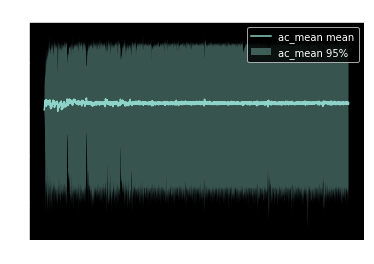

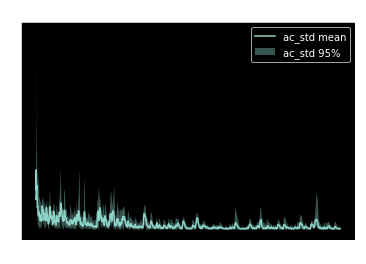

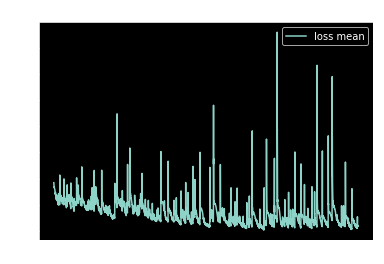

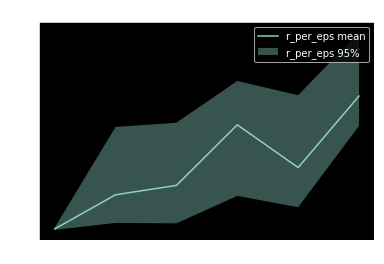

In [16]:
env_name = 'Hopper-v1'
train_params = TrainParams(
  num_steps=10001,  # was 50001
  mini_batch_size=1000,
  steps_per_policy_eval=1000,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [20]:
# Show an episode of the imitation policy
exps['Hopper-v1'].visualize()

Step: 5000. Expected reward: 1038.9297088981014


Reward: mean 1228.83, std 0.00 over 1 episodes.
Actual rewards: [[1228.8276332020012]]


[2018-01-28 15:57:57,557] Making new env: Ant-v1


From expert_rollouts/Ant-v1/n100_1.pkl
Loaded observations: (99265, 111)
Loaded actions: (99265, 8)


Step: 0; Loss: 0.9847607612609863; R: -151.77329358631576


Step: 500; Loss: -1.3151004314422607; R: 1681.87907295859


Step: 1000; Loss: -1.7115744352340698; R: 2558.3156335833964


Step: 1500; Loss: -1.0086281299591064; R: 2046.059611866281


Step: 2000; Loss: -2.2359673976898193; R: 4508.198844356931


Step: 2500; Loss: -2.275665044784546; R: 4605.052511556383


Step: 3000; Loss: -1.1410953998565674; R: 2600.7918178921436


Step: 3500; Loss: -2.3655385971069336; R: 4684.915156948217


Step: 4000; Loss: -2.3895716667175293; R: 4906.461464886893


Step: 4500; Loss: -2.644102096557617; R: 4679.617127763602


Step: 5000; Loss: -2.355576515197754; R: 3857.043140715893


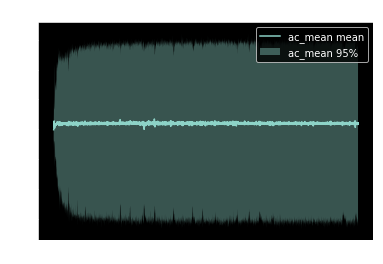

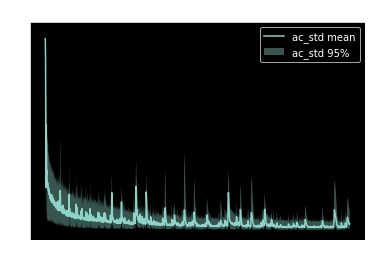

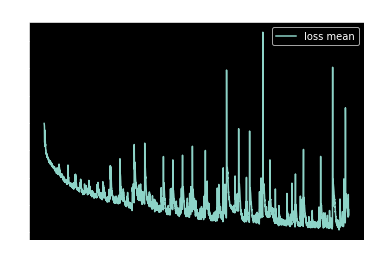

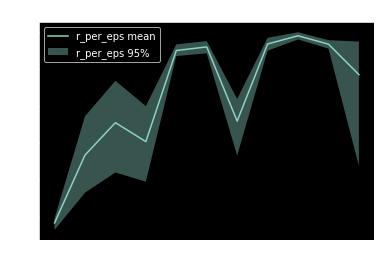

In [45]:
env_name = 'Ant-v1'
train_params = TrainParams(
  num_steps=5001,
  mini_batch_size=500,
  steps_per_policy_eval=500,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()



In [51]:
# Show an episode of the imitation policy
exps['Ant-v1'].visualize()


Reward: mean 4023.41, std 0.00 over 1 episodes.
Actual rewards: [[4023.407596137964]]


[2018-01-28 16:38:12,691] Making new env: HalfCheetah-v1


From expert_rollouts/HalfCheetah-v1/n100_1.pkl
Loaded observations: (100000, 17)
Loaded actions: (100000, 6)


Step: 0; Loss: 1.2086057662963867; R: -607.7744736737343


Step: 300; Loss: -0.5447344779968262; R: 698.2046435481374


Step: 600; Loss: -0.8952125906944275; R: 2428.9333138958496


Step: 900; Loss: -0.7336575388908386; R: 3208.810203674052


Step: 1200; Loss: -1.3893944025039673; R: 4109.279475422539


Step: 1500; Loss: -1.0110143423080444; R: 2842.867525299743


Step: 1800; Loss: -1.6141037940979004; R: 4059.0456537475984


Step: 2100; Loss: -1.7782347202301025; R: 4074.949499606453


Step: 2400; Loss: -1.8222477436065674; R: 4034.4159103549196


Step: 2700; Loss: -2.034633159637451; R: 4215.293752178581


Step: 3000; Loss: -1.7886015176773071; R: 4187.4791127358


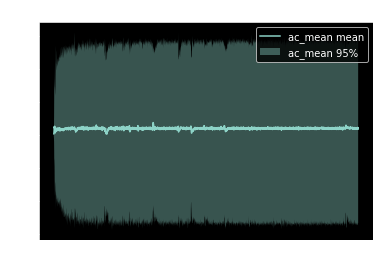

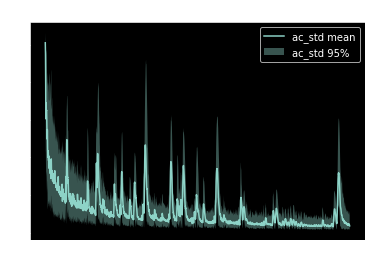

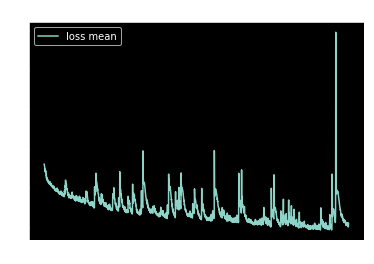

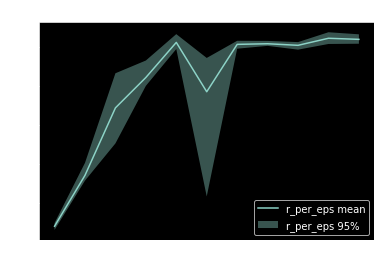

In [74]:
env_name = 'HalfCheetah-v1'
train_params = TrainParams(
  num_steps=3001,
  mini_batch_size=500,
  steps_per_policy_eval=300,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()



In [78]:
# Show an episode of the imitation policy
exps['HalfCheetah-v1'].visualize()


Step: 2700. Expected reward: 4215.293752178581


Reward: mean 4058.18, std 0.00 over 1 episodes.
Actual rewards: [[4058.181733072296]]


[2018-01-28 17:06:25,366] Making new env: Reacher-v1


From expert_rollouts/Reacher-v1/n100_1.pkl
Loaded observations: (5000, 11)
Loaded actions: (5000, 2)


Step: 0; Loss: 0.9691274762153625; R: -119.82116379870293


Step: 500; Loss: -3.092132091522217; R: -6.8078993400522


Step: 1000; Loss: -3.4575321674346924; R: -5.844205020442443


Step: 1500; Loss: -3.8899197578430176; R: -5.533290657269859


Step: 2000; Loss: -4.151736736297607; R: -5.375476685048888


Step: 2500; Loss: -3.9934866428375244; R: -5.557228806464453


Step: 3000; Loss: -4.809988975524902; R: -4.317785394067953


Step: 3500; Loss: -4.854434967041016; R: -4.325570173061233


Step: 4000; Loss: -1.7176358699798584; R: -8.970584913505183


Step: 4500; Loss: -4.516554832458496; R: -4.379245931791329


Step: 5000; Loss: -5.100255489349365; R: -6.246827517963335


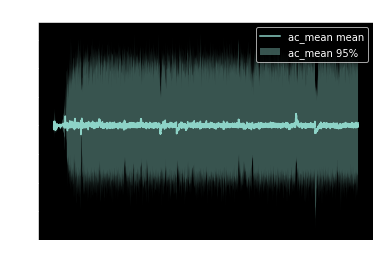

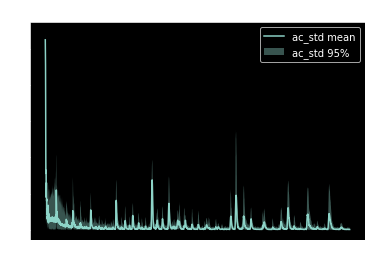

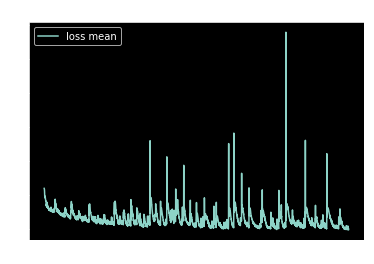

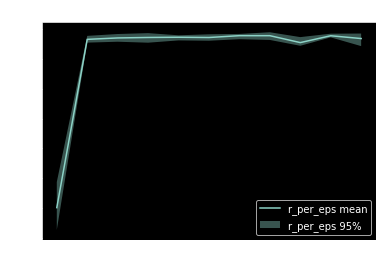

In [79]:
env_name = 'Reacher-v1'
train_params = TrainParams(
  num_steps=5001,
  mini_batch_size=500,
  steps_per_policy_eval=500,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [81]:
# Show an episode of the imitation policy
exps['Reacher-v1'].visualize(num_episodes=10)


Step: 3000. Expected reward: -4.317785394067953


Reward: mean -2.99, std 2.14 over 10 episodes.
Actual rewards: [[-2.83541853460701, -1.5761261735392216, -3.5030861061711596, -1.1703574922295308, -8.49789970747889, -3.9383509960206418, -3.4527570976892252, -0.7453823239240847, -1.070279844746793, -3.131126451155939]]


[2018-01-28 23:18:51,530] Making new env: Walker2d-v1


From expert_rollouts/Walker2d-v1/n20_1.pkl
Loaded observations: (20000, 17)
Loaded actions: (20000, 6)
Step: 0; Loss: 1.586344838142395; R: 1.0520117176755381


Step: 1000; Loss: -0.6223083734512329; R: 217.04206845715643


Step: 2000; Loss: -0.3530205190181732; R: 327.3809076069482


Step: 3000; Loss: -1.3627867698669434; R: 761.0991818610989


Step: 4000; Loss: -1.003460168838501; R: 985.5182118809195


Step: 5000; Loss: -1.2768322229385376; R: 1118.7555073053938


Step: 6000; Loss: -1.866660475730896; R: 993.9717602940298


Step: 7000; Loss: -1.3819140195846558; R: 1608.1169530315717


Step: 8000; Loss: -1.9412869215011597; R: 1088.6571267769957


Step: 9000; Loss: -1.665181279182434; R: 1670.2678093013685


Step: 10000; Loss: -1.721450686454773; R: 1854.0451077092898


Step: 11000; Loss: -1.6400388479232788; R: 2957.921545378157


Step: 12000; Loss: -1.8305606842041016; R: 2194.6040790587776


Step: 13000; Loss: -1.509121298789978; R: 2228.492046577171


Step: 14000; Loss: -0.29788267612457275; R: 702.2173956464296


Step: 15000; Loss: -1.5458827018737793; R: 1995.5609866686912


Step: 16000; Loss: -1.8170942068099976; R: 1419.9148425973572


Step: 17000; Loss: -1.7343240976333618; R: 1706.3597978775383


Step: 18000; Loss: -1.4099839925765991; R: 2832.824162035092


Step: 19000; Loss: -2.030876874923706; R: 1168.858378552636


Step: 20000; Loss: -1.1459006071090698; R: 1164.5750382712474


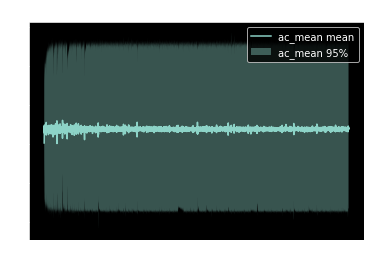

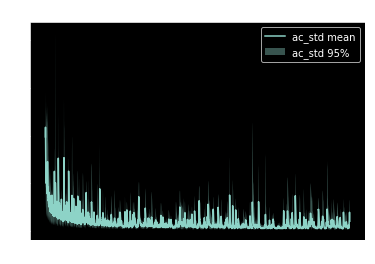

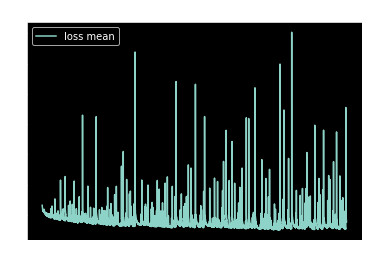

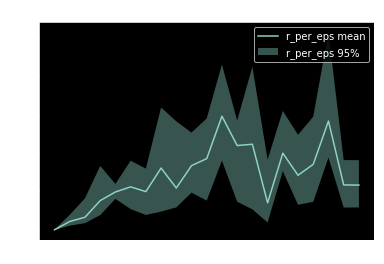

In [91]:
env_name = 'Walker2d-v1'
train_params = TrainParams(
  num_steps=20001,
  mini_batch_size=1000,
  steps_per_policy_eval=1000,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [92]:
# Show an episode of the imitation policy
exps['Walker2d-v1'].visualize()


Step: 11000. Expected reward: 2957.921545378157


Reward: mean 4281.39, std 0.00 over 1 episodes.
Actual rewards: [[4281.394595676173]]


In [100]:
env_name = 'Humanoid-v1'
train_params = TrainParams(
  num_steps=30001,
  mini_batch_size=1000,
  steps_per_policy_eval=1000,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()



[2018-01-28 23:41:12,593] Making new env: Humanoid-v1


From expert_rollouts/Humanoid-v1/n20_1.pkl
Loaded observations: (18172, 376)
Loaded actions: (18172, 17)


Step: 0; Loss: 1.5080134868621826; R: 87.50273502047408


Step: 1000; Loss: -0.20504441857337952; R: 377.5042877877793


Step: 2000; Loss: -0.421390563249588; R: 412.16114561203403


Step: 3000; Loss: -0.521059513092041; R: 304.44222774596204


Step: 4000; Loss: -0.7810347080230713; R: 428.9142675969635


RuntimeError: value cannot be converted to type double without overflow: -inf

In [90]:
# Show an episode of the imitation policy
exps['Humanoid-v1'].visualize()


Step: 7000. Expected reward: 894.0765988709509


Reward: mean 976.06, std 0.00 over 1 episodes.
Actual rewards: [[976.0635167223027]]
